# Before starting the note...
Useful tips for jupyter notebook:

https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

In [ ]:
#http://d.hatena.ne.jp/naraba/20121201/p1
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_01_installing.html

from music21 import *
#environment.set('musicxmlPath' , r"C:\Program Files (x86)\Finale NotePad 2012\Finale NotePad.exe")
#configure.run()
#environment.keys()
#environment.get('musicxmlPath')

楽譜を表示するためのおまじない

参考URL:https://groups.google.com/forum/#!topic/music21list/FmU6HeNm7AM


In [2]:
us = environment.UserSettings()
#us.create()
us['musicxmlPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
us['musescoreDirectPNGPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
%load_ext music21.ipython21

# 楽譜を構成する部品のヒエラルヒー 
## Music21のチュートリアルの構成（score, part, measure）

scoreとPartとMeasureがstreamの基本的なsubclass

scoreがpartを複数含み、partはmeasureを複数持つ、というのが基本的なScoreの構成

## deep jazzの場合のヒエラルヒー（上記と異なる）

deepjazzの例では

Score (midi_data) > Part (melody_stream) > Voice (melody1,2 , melody_voice) ＞ Note

という階層に従ってデータを切り出しているように見える。
すなわちPartはMeasureを持たず、その代わり（？）にVoiceを持っている：

In [3]:
s_jazz = converter.parse('C:/Users/t/PycharmProjects/deepjazz_in_a_file/midi/original_metheny.mid')

In [4]:
s_jazz_parts = [x for x in s_jazz.getElementsByClass(stream.Part)]
len(s_jazz_parts)

19

partは楽器が指定してあったりなかったり。

In [5]:
[x.getInstrument() for x in s_jazz.getElementsByClass(stream.Part)[0:10]]

[<music21.instrument.Instrument Piano>,
 <music21.instrument.Instrument Acoustic Bass>,
 <music21.instrument.Instrument >,
 <music21.instrument.Instrument >,
 <music21.instrument.Instrument >,
 <music21.instrument.Instrument Electric Guitar>,
 <music21.instrument.Instrument Trumpet>,
 <music21.instrument.Instrument Horn>,
 <music21.instrument.Instrument >,
 <music21.instrument.Instrument >]

In [6]:
s_jazz_part0_voices = [x for x in s_jazz_parts[0].getElementsByClass(stream.Voice)]
len(s_jazz_part0_voices)

5

partの構成要素であるvoiceにも同様にinstrumentが指定してあったりしなかったり。おそらく、partレベルで指定しておき、それが構成要素であるvoiceに遺伝している形か

In [7]:
[x.getInstrument() for x in s_jazz_parts[0].getElementsByClass(stream.Voice)]

[<music21.instrument.Instrument Piano>,
 <music21.instrument.Instrument Piano>,
 <music21.instrument.Instrument Piano>,
 <music21.instrument.Instrument Piano>,
 <music21.instrument.Instrument Piano>]

In [8]:
s_jazz_part0_voices.show()

AttributeError: 'list' object has no attribute 'show'

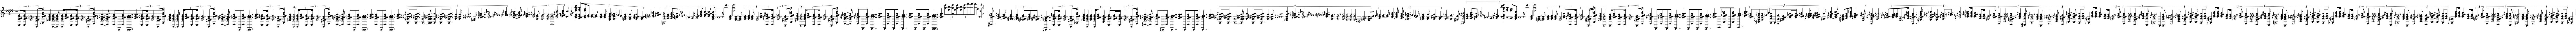

In [9]:
s_jazz_part0_voices[0].show()

VoiceのなかにMeasureがあるかと思いきやそんなものはない：

In [10]:
len(s_jazz_part0_voices[0].getElementsByClass(stream.Measure))

0

ではなにが入っているかといえば、（ScoreのなかのPartのなかの）各PartのVoice[0]はおおむねChordから構成されている（他はnote.Rest, note.Noteが少々）：

In [11]:
"   ".join([str(type(x)) for x in s_jazz_part0_voices[0][0:20]])

"<class 'music21.note.Rest'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>   <class 'music21.note.Note'>   <class 'music21.chord.Chord'>   <class 'music21.chord.Chord'>"

おそらく各パートのvoice[1]以降はおおむねnoteから構成されている（？）

であるが、deepjazzでchordパートを切り出す際にはそのように決め打つことなく、solo_stream[0]からremoveByClassでnoteを除外しつつすべてのchordを抽出している。
また、melodyパートはsolo_stream[-1]から特に除外操作をすることなくすべてのnoteを抽出できている（？）

In [12]:
"   ".join([str(type(x)) for x in s_jazz_part0_voices[1][0:20]])

"<class 'music21.note.Rest'>   <class 'music21.note.Note'>   <class 'music21.note.Rest'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>   <class 'music21.note.Note'>"

# deep jazzにおける measures, chordsの生成手順

- part 0 , 1 , 6 ,7をcomp_streamに突っ込む
 - part 0は以下のような感じで和音が入っている(Piano?)
<img src = "comp_stream0.png">
 - part 1 は以下のような感じで単音で入っている(Acoustic Bass?)
 <img src = "comp_stream1.png">

- さらにメロディーパートであるPart 5(Electric Guitar?)をfull_streamに格納
- offset 476から548がソロなのでそこを切り取って、solo_streamに格納

memo : Piano（パート0)が和音を担当し、melody（Electric Guitar, part 5)のその周りでのdynamicsを記述するというピクチャーか？
それだと、その他のpartの役割がわからない。to be figured outだが、
- solo_streamは最初のpart(ピアノ・和音)と最後のpart(Electric Guitar・メロディ)以外使われている形跡がない



# abstract grammar
abstract grammarは
http://ai.stanford.edu/~kdtang/papers/smc09-jazzgrammar.pdf
に記述がある。以下解読を試みる

## Abstract grammarのSymbol
### abstract_grammar論文のSymbol S
deep jazzの__is_scale_toneでは和音が属している（deriveで推定）音階に入っている音かどうかを判定している

### Symbol C
和音自体の構成音とのマッチング判定をしている

### Symbol A
和音の構成音±１かどうかを判定

（Δ 1 2 S8 S8 S8)は
- 上記の分類でSとなる八分音符が音が高くなる形で３つ続く
- 各音の間のpitchは最低で１半音、最大で２半音

であることを意味している

このabstract grammarのポイント
- 「上がり始めるとしばらく上がっている傾向が強い」というmomentum的な傾向があること
- 上昇・下降スピードが一定範囲以内であればある種の同一視が可能なこと


- 上昇・下降が連続しない場合、本来であれば速度の「上限＝下限」となるが、半音ずつ緩めたほうが良いとのこと

### 参考情報

Cruz-Alcazar and Vidal-RuizはGregorian, Bach, JoplinでGrammatical Inferenceに基づき、音楽を生成。Gregorianのパフォーマンスが最もよかった。


Pedro P. Alcazar and Enrique Vidal-Ruiz, “Learning
Regular Grammars to Model Musical Style: Comparing
Different Coding Schemes”, Proceedings of 4th ICGI, 211-
222, 1998.

## (参照論文中のアルゴリズム)Markov chain

推移行列を推定するために似た「abstract measures」をK-meansでクラスタリングする。この際以下の7次元のユークリッド空間に各abstract measureをマップして行う

(note数, window内の最初の音の位置 , restのtotal duration , 上昇スロープおよび下降スロープの勾配絶対値の平均 , on the beatからスタートするか , 上昇・下降の切り替わりの回数　, consonance)

ただし、consonaneは以下のスコアの合計
- chord note : 0.8
- approach note : 0.6
- color note : 0.4
- その他 : 0.1


## Deep jazz code上のabstract grammarの表現・表記

- 論文でR8と表記されているもの->R,0.125に
- slopeの上限、下限は論文では半音数表記だが、deep jazzコード上はM3(すなわちMajor 3rd, 長三度)といった表記

## deep jazzにおけるabstract grammar構成手順
- measuresとchordsは同じ数の要素を持つorderedDict
- 例えばix番目のmeasureとchordからそれぞれstream.Voice(m , c)を作る
- m,cをparse_melodyに突っ込む

mは以下のような感じ
<img src='m.png'>

それに対してcは以下のような感じ

## parse_melodyが何をやっているか？
m(measure。エレキギターの旋律)とc(chords)をとってきて
mの各音(nr)に対して
- mと時点が一致するかmよりも過去のlastChordを探す。存在しないときはcのなかの最初のchordをlastChordとする
- それぞれのnrについて、lastChordとの相対位置などから以下で説明しているabstract grammarの最初のSymbolを決定
- 次に音の長さを記載。次の音がある場合は次の音の開始位置とnr.offsetの差。次の音がない場合、measureStartTimeに４を足して、nr.offsetとの差分をとる。（なお、ノーテーションが論文と異なる。下記注釈参照）
- 最後にデルタを決定。
 - 直前の音との音程の差をもとにm3ずつ上下に広げている
 - 論文と異なり、momentum的な構造は考慮しておらず、直前の音との関係だけを見ている。ここは改良の余地があるかもしれない

# Abstract grammarを得たあとの処理

get_corpus_dataによって以下を生成：

- corpus(list)はabstract_grammar(list)を上昇、下降単位に分解したもの
- valuesはcorpusのset化したもの
- val_indicesはvaluesに番号をつけたものをvalues側から引けるようにしたもの
- indices_valは逆に番号側から引けるようにしたもの

これでLSTMに突っ込む準備ができた！

## LSTMのmodel build

- sentencesはlistのlist
- next_valuesはstrのlist

- X,yはboolをとるnumpy.ndarrayなのでTrue, Falseがだーと並んでるがたぶん問題ない


## Generation part

### __generate_grammarのなかでやっていること

- corpusからランダムに開始位置を決め、そこからmax_len個の"word"(abstract grammar)をとってきてsentenceに格納
- sentenceをtoken化してxに格納
- xからnext_val(これもcorpusと同じ粒度のword or abstract grammar)をLSTMでpredict
 - ただし、最初の音に関しては 'S,0.333'みたいな音でなくてはならない。すなわち、
   - 'X,0.250,<d1,P-5>' みたいな<>が入っている表現ではダメで、かつ、
   - 休止符であってもいけない
   
   この条件をみたすまでpredictを繰り返す（結構何回も必要なはず？）
- next_valから  長さ情報を抜き出す
- sentenceの最後にnext_valを付け加える
- 長さの合計が４を超えたらexit

返り値のcurr_grammarはstrであることに注意


### unparse_grammar
curr_grammarとcurr_chordから具体的なnoteに展開